# European Regas Slots Availability vs US Front Month Arb

This script allows you to plot European terminal slot availability levels against the Front Month US Arb, utilising Spark Access and Spark Cargo data.

This script uses elements from our API code samples. If you'd like a more basic and informative example of how to pull data via the Spark API, please visit our Github or API website:

- Github: https://github.com/spark-commodities/api-code-samples/blob/master/jupyter_notebooks/
- API Website: https://www.sparkcommodities.com/api/code-examples/jupyter.html


### Have any questions?

If you have any questions regarding our API, or need help accessing specific datasets, please contact us at:

__data@sparkcommodities.com__

or refer to our API website for more information about this endpoint:
https://www.sparkcommodities.com/api/request/access.html

__N.B. This script requires both Cargo and Access subscriptions__

## 1. Importing Data

Here we define the functions that allow us to retrieve the valid credentials to access the Spark API.

This section can remain unchanged for most Spark API users.

In [20]:
# import libraries for importing data
import json
import os
import sys
import pandas as pd
from base64 import b64encode
from urllib.parse import urljoin
from pprint import pprint
import requests
from io import StringIO
import time
import numpy as np

try:
    from urllib import request, parse
    from urllib.error import HTTPError
except ImportError:
    raise RuntimeError("Python 3 required")


In [22]:

API_BASE_URL = "https://api.sparkcommodities.com"


def retrieve_credentials(file_path=None):
    """
    Find credentials either by reading the client_credentials file or reading
    environment variables
    """
    if file_path is None:
        client_id = os.getenv("SPARK_CLIENT_ID")
        client_secret = os.getenv("SPARK_CLIENT_SECRET")
        if not client_id or not client_secret:
            raise RuntimeError(
                "SPARK_CLIENT_ID and SPARK_CLIENT_SECRET environment vars required"
            )
    else:
        # Parse the file
        if not os.path.isfile(file_path):
            raise RuntimeError("The file {} doesn't exist".format(file_path))

        with open(file_path) as fp:
            lines = [l.replace("\n", "") for l in fp.readlines()]

        if lines[0] in ("clientId,clientSecret", "client_id,client_secret"):
            client_id, client_secret = lines[1].split(",")
        else:
            print("First line read: '{}'".format(lines[0]))
            raise RuntimeError(
                "The specified file {} doesn't look like to be a Spark API client "
                "credentials file".format(file_path)
            )

    print(">>>> Found credentials!")
    print(
        ">>>> Client_id={}****, client_secret={}****".format(
            client_id[:5], client_secret[:5]
        )
    )

    return client_id, client_secret

def do_api_post_query(uri, body, headers):
    """
    OAuth2 authentication requires a POST request with client credentials before accessing the API. 
    This POST request will return an Access Token which will be used for the API GET request.
    """
    url = urljoin(API_BASE_URL, uri)

    data = json.dumps(body).encode("utf-8")

    # HTTP POST request
    req = request.Request(url, data=data, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 201, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content

def do_api_get_query(uri, access_token):
    url = urljoin(API_BASE_URL, uri)

    headers = {
        "Authorization": "Bearer {}".format(access_token),
        "Accept": "application/json",
    }

    # HTTP POST request
    req = request.Request(url, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 200, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content

def get_access_token(client_id, client_secret):
    """
    Get a new access_token. Access tokens are the thing that applications use to make
    API requests. Access tokens must be kept confidential in storage.

    # Procedure:

    Do a POST query with `grantType` and `scopes` in the body. A basic authorization
    HTTP header is required. The "Basic" HTTP authentication scheme is defined in
    RFC 7617, which transmits credentials as `clientId:clientSecret` pairs, encoded
    using base64.
    """

    # Note: for the sake of this example, we choose to use the Python urllib from the
    # standard lib. One should consider using https://requests.readthedocs.io/

    payload = "{}:{}".format(client_id, client_secret).encode()
    headers = {
        "Authorization": b64encode(payload).decode(),
        "Accept": "application/json",
        "Content-Type": "application/json",
    }
    body = {
        "grantType": "clientCredentials",
        "scopes":  "read:netbacks,read:access,read:prices,read:routes",
    }

    content = do_api_post_query(uri="/oauth/token/", body=body, headers=headers)

    print(
        ">>>> Successfully fetched an access token {}****, valid {} seconds.".format(
            content["accessToken"][:5], content["expiresIn"]
        )
    )

    return content["accessToken"]

def list_netbacks(access_token):
    """
    Fetch available routes. Return contract ticker symbols

    # Procedure:

    Do a GET query to /v1.0/routes/ with a Bearer token authorization HTTP header.
    """
    content = do_api_get_query(uri="/v1.0/netbacks/reference-data/", access_token=access_token)

    print(">>>> All the routes you can fetch")
    tickers = []
    fobPort_names = []

    availablevia = []

    for contract in content["data"]['staticData']['fobPorts']:
        
        tickers.append(contract["uuid"])
        fobPort_names.append(contract['name'])
        
        availablevia.append(contract['availableViaPoints'])
    
    reldates = content["data"]['staticData']['sparkReleases']
        
    dicto1 = content["data"]
        
    return tickers, fobPort_names, availablevia, reldates, dicto1
    #return dicto1


### N.B. Credentials

N.B. You must have downloaded your client credentials CSV file before proceeding. Please refer to the API documentation if you have not dowloaded them already. Instructions for downloading your credentials can be found here:

https://api.sparkcommodities.com/redoc#section/Authentication/Create-an-Oauth2-Client

In [23]:
# Insert file path to your client credentials here
client_id, client_secret = retrieve_credentials(file_path="/tmp/client_credentials.csv")

# Authenticate:
access_token = get_access_token(client_id, client_secret)

>>>> Found credentials!
>>>> Client_id=875f4****, client_secret=6cdf8****
>>>> Successfully fetched an access token eyJhb****, valid 604799 seconds.


## 2. Slots Data
Importing historical slot data from the Spark API. For more information on pulling our regas slot data, please refer to our Spark API website: 

https://www.sparkcommodities.com/api/

In [24]:
# Function to get the list of terminals and their uuids (as well as their start and latest release date)
def get_terminal_list():
    uri = urljoin(API_BASE_URL,'beta/terminal-slots/terminals/')
    headers = {
            "Authorization": "Bearer {}".format(access_token),
            "accept": "text/csv"
        }
    response = requests.get(uri, headers=headers)
    if response.status_code == 200:
        df = response.content.decode('utf-8')
        df = pd.read_csv(StringIO(df))
    else:
        print('Bad Request')
    return df

In [25]:
# Call terminal list function
terminal_list = get_terminal_list()
terminal_list.head(20)

,TerminalUUID,TerminalCode,TerminalName,firstAvailableRelease,latestAvailableRelease
0,00317185-978a-4df5-970c-2c28d3ab893c,grain-lng,Isle of Grain,2023-11-28,2025-01-15
1,0031994e-f370-4927-ba88-a4e7a78c42db,zeebrugge,Zeebrugge,2023-11-28,2025-01-15
2,00338f3f-8875-435d-87a9-f83d9a5c5241,dunkerque,Dunkerque,2024-11-15,2025-01-15
3,00344dd2-5608-4413-a2f4-c52c747a286a,dragon,Dragon,2023-11-28,2025-01-15
4,003497c6-ed32-412f-95ef-c3b1f962464e,brunsbuttel,Brunsbuttel,2024-05-28,2025-01-15
5,00355021-dc45-4aaa-8178-a6dc360c07b9,olt-toscana,OLT Toscana,2024-10-02,2025-01-15
6,00361ab8-f70d-4a08-8e45-e6eb5a0b8b2f,le-havre-fsru,Le Havre,2023-11-28,2025-01-15
7,003660ee-567d-4d23-9e43-2891509b7bfb,piombino-fsru,Piombino,2023-12-18,2025-01-15
8,0037d9e4-cf09-4f26-8934-f1e038e185ea,eems-energy-terminal,EemsEnergyTerminal,2024-09-05,2025-01-15
9,0038a35c-253f-44f5-a4e5-d5240d98039a,adriatic,Adriatic,2024-10-02,2025-01-15


In [26]:
# Function to collect and store historical slots for one specific terminal
def get_individual_terminal(terminal_uuid):
    uri = urljoin(API_BASE_URL, f'/beta/terminal-slots/terminals/{terminal_uuid}/')
    headers = {
            "Authorization": "Bearer {}".format(access_token),
            "accept": "text/csv"
        }
    response = requests.get(uri, headers=headers)
    if response.status_code == 200:
        df = response.content.decode('utf-8')
        df = pd.read_csv(StringIO(df))
        return df

    elif response.content == b'{"errors":[{"code":"object_not_found","detail":"Object not found"}]}':
        print('Bad Terminal Request')
        return None
    else:
        print('Bad Request')
        return None

In [27]:
# Function to collect and store each terminal's historical slots data
def get_all_terminal_data(terminal_list):
    terminals_all = pd.DataFrame()
    for i in range(len(terminal_list)):
        terminal_df = get_individual_terminal(terminal_list['TerminalUUID'].loc[i])
        time.sleep(0.1)
        terminals_all = pd.concat([terminals_all,terminal_df])
    return terminals_all

In [28]:
# Calling all terminal data function
all_terminal_historical = get_all_terminal_data(terminal_list)
all_terminal_historical.head()

,TerminalCode,TerminalName,ReleaseDate,Total,M+0,M+1,M+2,M+3,M+4,M+5,...,M+4StartDate,M+5StartDate,M+6StartDate,M+7StartDate,M+8StartDate,M+9StartDate,M+10StartDate,M+11StartDate,M+12StartDate,M>12StartDate
0,grain-lng,Isle of Grain,2023-11-28,1,0,1,0,0,0,0,...,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01
1,grain-lng,Isle of Grain,2023-11-29,1,0,1,0,0,0,0,...,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01
2,grain-lng,Isle of Grain,2023-11-30,2,2,0,0,0,0,0,...,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01
3,grain-lng,Isle of Grain,2023-12-01,2,2,0,0,0,0,0,...,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01
4,grain-lng,Isle of Grain,2023-12-04,2,2,0,0,0,0,0,...,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01


### Defining which terminal slots to sum up

Here we define which terminals we're interested in ('termlist'). We iterate through each release date, and sum up the total [M+0, M+1, M+2, M+3] slots for all chosen terminals, to gauge the overall demand for regasification slots in NWE.

In [39]:
# Function to define terminals and to sum the slot count

def select_and_sum_terminals(termlist, historical_terminals_data):

    # Unique release dates
    termrels = pd.Series(historical_terminals_data['ReleaseDate'].unique()).sort_values().to_list()[::-1]
    term_groups = historical_terminals_data.groupby('ReleaseDate')    

    slots = []

    for t in termrels:
        df = term_groups.get_group(t)
        
        df1 = df[df['TerminalName'].isin(termlist)]
        slots.append(df1['M+0'].sum() + df1['M+1'].sum() + df1['M+2'].sum() + df1['M+3'].sum())
    return slots


In [40]:
# Define terminals of interest

termlist = ['Gate', 'Zeebrugge', 'Dunkerque', 'Fos Cavaou']


# Call the function
slots = select_and_sum_terminals(termlist, all_terminal_historical)

## 3. Importing Spark Netbacks - US Arb data 

Importing historical US front month arb data from the Spark API. For more information on pulling our netbacks data, please refer to our Spark API website: 

https://www.sparkcommodities.com/api/

In [30]:
# List all netbacks available

tickers, fobPort_names, availablevia, reldates, dicto1 = list_netbacks(access_token)

>>>> All the routes you can fetch


In [31]:
## Defining the function

def fetch_netback(access_token, ticker, release, via=None, laden=None, ballast=None):
    
    query_params = "?fob-port={}".format(ticker)
    if release is not None:
        query_params += "&release-date={}".format(release)
    if via is not None:
        query_params += "&via-point={}".format(via)
    if laden is not None:
        query_params += "&laden-congestion-days={}".format(laden)
    if ballast is not None:
        query_params += "&ballast-congestion-days={}".format(ballast)

    
    content = do_api_get_query(
        uri="/v1.0/netbacks/{}".format(query_params),
        access_token=access_token,
    )
    
    my_dict = content['data']

    return my_dict


### Netbacks Historical Data Function

Here we define a function to fetch the historical netbacks data from the Spark API. 

__N.B. This function takes a "month" parameter - this parameter is defined as the month up until which you would like to sum the arb data.__

E.g. :
- "month=1" will provide the M+1 US arb data
- "month=2" will provide the mean value of the M+1 and M+2 US arb
- "month=3" will provide the mean value of the [M+1, M+2, M+3] US arb
- and so on.

In [32]:
import time

def netbacks_history(tick, reldates, month=1, my_via=None, laden =None, ballast=None):

    delta_outrights = []
    release_date = []
    
    port = []

    for r in reldates:
        try:
            my_dict = fetch_netback(access_token, tickers[tick], release=r, via=my_via, laden=laden, ballast=ballast)

            dtemp = []
            for m in my_dict['netbacks'][0:month]:
                dtemp.append(float(m['neaMinusNwe']['outright']['usdPerMMBtu']))
            delta_outrights.append(np.mean(dtemp))

            release_date.append(my_dict['releaseDate'])
            port.append(fobPort_names[tick])

        except:
            print('Bad Date: ' + r)
        
        time.sleep(0.5)
        
    historical_df = pd.DataFrame({
                'Release Date': release_date,
                'FoB Port': port,
                'Delta Outrights': delta_outrights,
                })
    

    historical_df['Release Date'] = pd.to_datetime(historical_df['Release Date'])
    
    return historical_df


In [33]:
# Calling the function and importing the US arb data

via ='cogh'
my_t = 'Sabine Pass'
t = fobPort_names.index(my_t)
my_date = reldates.index('2024-01-05')

my_rels = reldates[:my_date]

df_cogh = netbacks_history(t, my_rels, month=3, my_via='cogh')

### Combine Datasets and Final Charts

In [34]:
# Combining Slots and US arb data into one single DataFrame

slots_df = pd.DataFrame({
    'Release Date': df_cogh['Release Date'],
    'Arb' : df_cogh['Delta Outrights'],
    'Slots' : slots[:my_date]
})


# Displaying Slots data

slots_df.head()

,Release Date,Arb,Slots
0,2025-01-15,-0.769000,8
1,2025-01-14,-0.726333,10
2,2025-01-13,-0.658000,10
3,2025-01-10,-0.574000,11
4,2025-01-09,-0.606333,13


## 4. Plotting

### Daily Slots Data vs US Arb Chart

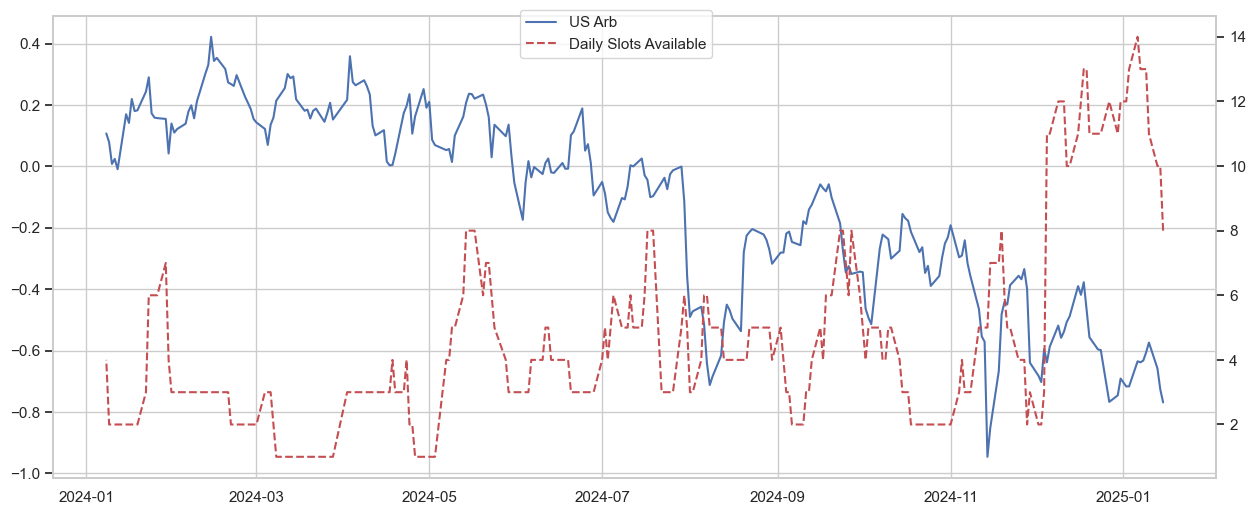

In [35]:
# Plotting

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(slots_df['Release Date'], slots_df['Arb'], label='US Arb')

ax2 = ax.twinx()
ax2.plot(slots_df['Release Date'], slots_df['Slots'], 'r--', label='Daily Slots Available')

ax2.grid(False)

fig.legend(loc = 'center', bbox_to_anchor=(0.5, 0.85))

### Month Average Slots vs US Arb Chart

In [41]:
# Calculating the average slots per month from the daily data

def calculate_average_slots_per_month(slots_df):
    # Retrieving the months
    month_times = []
    for t in slots_df['Release Date'].to_list():
        month_times.append(t.strftime("%b-%Y"))

    slots_df['Release Month'] = month_times


    # Averaging over each month
    month_groups = slots_df.groupby('Release Month')

    m_aves_raw = []

    for m in list(np.unique(month_times)):
        mdf = month_groups.get_group(m)
        m_aves_raw.append(mdf['Slots'].mean())
    
    # Storing in one "Monthly" DataFrame
    monthly_slots = pd.DataFrame({
        "Month": list(np.unique(month_times)),
        "Slots": m_aves_raw
    })

    monthly_slots['Month'] = pd.to_datetime(monthly_slots['Month'])

    return monthly_slots, slots_df



In [42]:
# Calling the function

monthly_slots, slots_df = calculate_average_slots_per_month(slots_df)

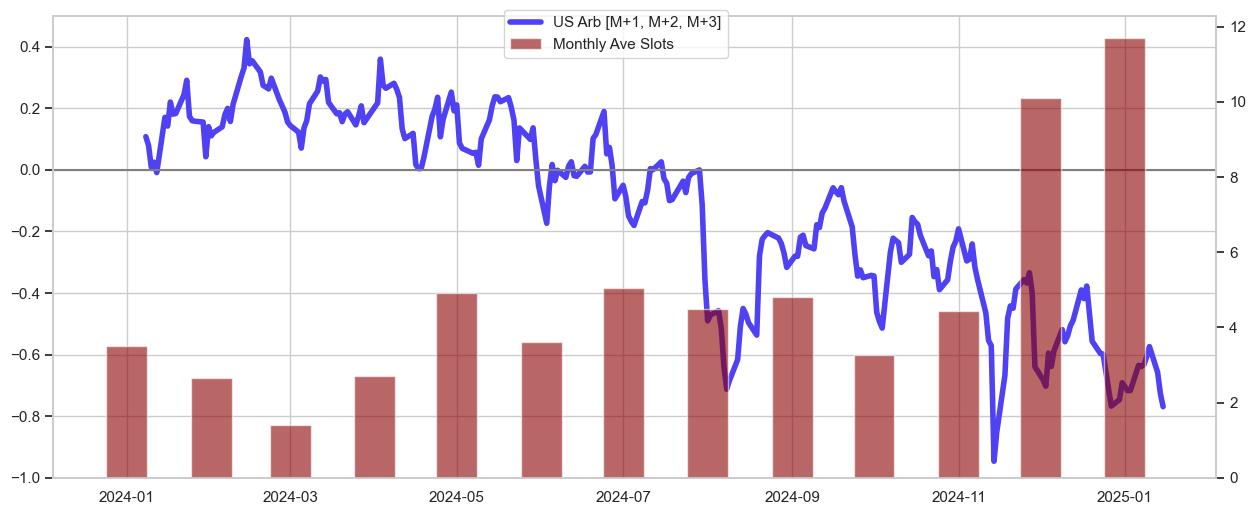

In [43]:
# Plotting

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(slots_df['Release Date'], slots_df['Arb'], color='#4F41F4', label='US Arb [M+1, M+2, M+3]', linewidth=4)
plt.axhline(0, color='grey')

ax2 = ax.twinx()
ax2.bar(monthly_slots['Month'], monthly_slots['Slots'], width=15.0, color='darkred', alpha=0.6, label='Monthly Ave Slots')

ax.set_ylim(-1,0.5)

ax2.grid(False)

plt.title('')

fig.legend(loc = 'center', bbox_to_anchor=(0.5, 0.85))